<a href="https://colab.research.google.com/github/kuretaru/topo-ml-spin-phases/blob/develop/2_2_The_%22Hidden%22_Data_%26_Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base imports

In [ ]:
!pip install gudhi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 30.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import gudhi
import matplotlib.pyplot as plt

# Preparing data

In [ ]:
!wget https://raw.githubusercontent.com/kuretaru/topo-ml-spin-phases/main/materials/lessons/1_3_dataset/data_x.npy
!wget https://raw.githubusercontent.com/kuretaru/topo-ml-spin-phases/main/materials/lessons/1_3_dataset/data_y.npy

--2025-12-07 19:50:59--  https://raw.githubusercontent.com/kuretaru/topo-ml-spin-phases/main/materials/lessons/1_3_dataset/data_x.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 720128 (703K) [application/octet-stream]
Saving to: ‘data_x.npy’

data_x.npy          100%[===================>] 703.25K  --.-KB/s    in 0.1s    

2025-12-07 19:51:00 (4.65 MB/s) - ‘data_x.npy’ saved [720128/720128]

--2025-12-07 19:51:00--  https://raw.githubusercontent.com/kuretaru/topo-ml-spin-phases/main/materials/lessons/1_3_dataset/data_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP reque

# Theory and Algorithm

**The Mystery of the Missing Dots**
You observed that the Hot diagram (`X[99]`) only showed a few dots.
*   **The Reality:** Since your data is binary (only `-1` and `1`), many loops correspond to the *exact same* birth/death values.
*   **The Result:** The dots are **stacked** on top of each other. You see 1 red dot, but there might be 100 dots underneath it!

We need to convert these diagrams into **Vectors** (numbers) that a Machine Learning model can understand. We cannot feed a "picture" of a diagram into a Logistic Regression.

We will use **Persistence Entropy**.
*   **Concept:** It measures how "chaotic" the topology is.
*   **Hypothesis:**
    *   **Ordered (Cold):** Low Entropy (Simple structure).
    *   **Disordered (Hot):** High Entropy (Complex structure).

#### Original Code: From Diagrams to Features

We will use `gudhi.representations.Entropy`.

In [ ]:
import numpy as np
import gudhi
import matplotlib.pyplot as plt
from gudhi.representations import Entropy

# 1. Load Data
X = np.load('data_x.npy')
y = np.load('data_y.npy')

def get_entropy(lattice):
    """
    Calculates the Topological Entropy of a lattice.
    """
    # 1. Build Complex
    cc = gudhi.CubicalComplex(dimensions=lattice.shape,
                              top_dimensional_cells=lattice.flatten())

    # 2. Compute Persistence
    # homology_coeff_field=2 is standard for binary data
    persistence = cc.persistence(homology_coeff_field=2)

    # OPTIONAL: Check the true number of features
    # print(f"Number of features: {len(persistence)}")

    # 3. Calculate Entropy
    # We only care about dimension 1 (loops/holes) for now, or use all.
    # Let's use the whole diagram.
    entropy_calc = Entropy()

    # Gudhi expects a list of diagrams, so we wrap [persistence]
    # It returns a list of values, we take the first one [0]
    # We flatten the result to get a single number.
    ent_value = entropy_calc.fit_transform([persistence])[0][0]

    return ent_value

# --- Test on Cold vs Hot ---
cold_entropy = get_entropy(X[0]) # Cold sample
hot_entropy = get_entropy(X[-1]) # Hot sample

print(f"Cold Entropy: {cold_entropy:.4f}")
print(f"Hot Entropy:  {hot_entropy:.4f}")

# 📝Assignments (Feature Engineering)

Task 1: **The "Hidden" Dots Proof**

Modify the get_entropy function (or write a small script) to print the len(persistence) for X[0] and X[-1].

    Expected result: Cold should have a small number (e.g., 1-5). Hot should have a large number (e.g., 50-200).

    Comment: Confirm if the "Stacking" theory was correct.

**Modified code:**

In [ ]:
import numpy as np
import gudhi
import matplotlib.pyplot as plt
from gudhi.representations import Entropy


def get_entropy(lattice):
    """
    Calculates the Topological Entropy of a lattice (Dimension 1 only).

    Args:
      lattice (np.ndarray): Lattice of the input data.

    Returns: Entropy value (float)
    """
    # 1. Build Complex
    cc = gudhi.CubicalComplex(dimensions=lattice.shape,
                              top_dimensional_cells=lattice.flatten())

    # 2. Compute Persistence
    cc.persistence()

    # 3. Extract ONLY Dimension 1 intervals (Holes)
    # This returns a numpy array of shape (N, 2) -> [[birth, death], ...]
    intervals = cc.persistence_intervals_in_dimension(1)

    # Safety Check: If the lattice is perfectly ordered, there are NO holes.
    # Entropy of nothing is 0.
    if len(intervals) == 0:
        return 0.0

    # 4. Calculate Entropy
    entropy_calc = Entropy()

    # We pass [intervals] because the function expects a LIST of diagrams
    ent_value = entropy_calc.fit_transform([intervals])[0][0]

    return ent_value


if __name__ == "__main__":
  # Load data if not already loaded
  X = np.load('data_x.npy')
  y = np.load('data_y.npy')

  # --- Verification & Task 1 (Corrected) ---

  # 1. Check Cold Sample (Index 0)
  cc_cold = gudhi.CubicalComplex(dimensions=X[0].shape,
                                top_dimensional_cells=X[0].flatten())
  cc_cold.persistence() # <--- CRITICAL STEP: Compute first!
  cold_intervals = cc_cold.persistence_intervals_in_dimension(1)

  print(f"Cold Sample (X[0]): Found {len(cold_intervals)} loops (H1 features).")
  print(f"Entropy: {get_entropy(X[0])}")

  # 2. Check Hot Sample (Index 99)
  cc_hot = gudhi.CubicalComplex(dimensions=X[-1].shape,
                                top_dimensional_cells=X[-1].flatten())
  cc_hot.persistence() # <--- CRITICAL STEP
  hot_intervals = cc_hot.persistence_intervals_in_dimension(1)

  print(f"Hot Sample (X[99]): Found {len(hot_intervals)} loops (H1 features).")
  print(f"Entropy: {get_entropy(X[-1])}")

Cold Sample (X[0]): Found 0 loops (H1 features).
Entropy: 0.0
Hot Sample (X[99]): Found 23 loops (H1 features).
Entropy: 3.1354942159291497


**Task 2: Build the Feature Matrix**
Create a loop to process **all 100 samples**.
1.  Create an empty list `features_list`.
2.  Loop through every lattice in `X`.
3.  Calculate its Entropy.
4.  Append the value to the list.
5.  Convert the list to a Numpy array shaped `(100, 1)`. Call it `X_features`.

In [22]:
feature_list = []

if __name__ == "__main__":
  # Load data if not already loaded
  X = np.load('data_x.npy')
  y = np.load('data_y.npy')

  print("Calculating entropy for all samples...")

  feature_list = [get_entropy(lattice) for lattice in X]

  X_features = np.array(feature_list).reshape(-1, 1)

  print(f"Feature Matrix Shape: {X_features.shape}")
  print("Sample values (first 5):")
  print(X_features[:5])
  print("Sample values (last 5):")
  print(X_features[94:99])

Calculating entropy for all samples...
Feature Matrix Shape: (100, 1)
Sample values (first 5):
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
Sample values (last 5):
[[2.89037176]
 [2.7080502 ]
 [2.94443898]
 [2.56494936]
 [2.89037176]]


**Task 3: Visualization (The "Aha!" Moment)**
Now you have `X_features` (entropy values) and `y` (labels 0 and 1).
Plot them:
```python
plt.scatter(range(100), X_features, c=y, cmap='coolwarm')
plt.xlabel("Sample Index")
plt.ylabel("Topological Entropy")
plt.title("Can we separate Cold (Blue) and Hot (Red)?")
plt.show()
```

**Goal:** If you see a clear separation (step function) in the graph, **you have successfully detected the phase transition using TDA.**

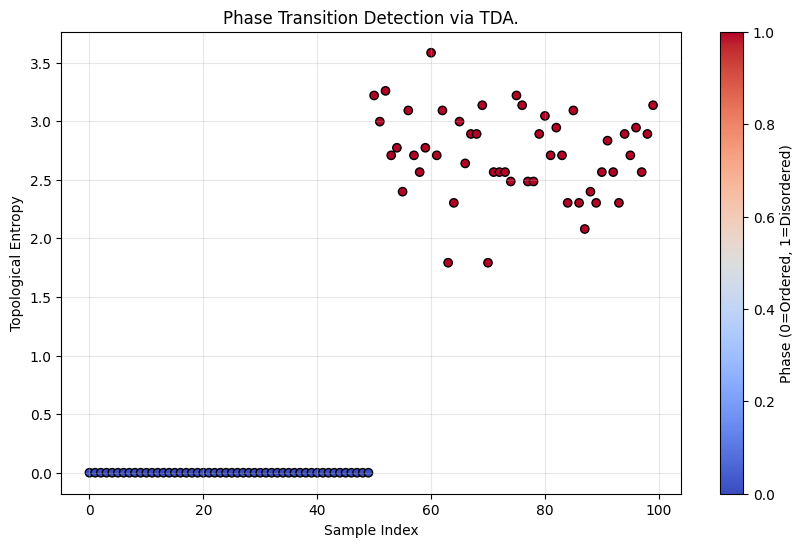

In [23]:
if __name__ == "__main__":
  plt.figure(figsize=(10, 6))

  # Scatter plot:
  # x-axis = Sample ID (0 to 99)
  # y-axis = Entropy
  # c (color) = Label (0 is Blue/Cold, 1 is Red/Hot)
  plt.scatter(range(100), X_features, c=y, cmap='coolwarm', edgecolor="k")

  plt.xlabel("Sample Index")
  plt.ylabel("Topological Entropy")
  plt.title("Phase Transition Detection via TDA.")
  plt.colorbar(label="Phase (0=Ordered, 1=Disordered)")
  plt.grid(True, alpha=0.3)
  plt.show()
